- Authors: William Wiemann, Tyler Carr, Benjamin Ranew
- Project title: Mercari Price Prediction Project
- File description: This is the main file that creates the model, runs the model, and gets predictions. It starts out by using [get_sample.py](get_sample.py) to get a consistent data sample of training and testing data. Then, using transformers, it creates two different pipelines, both using KNN as the model. One pipeline is created for text data, and another for categorical data. The two models are ensembled together using VotingRegressor. After the model is run, price predictions put next to the actual prices.

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from get_sample import get_sample
from get_tfidf_df import apply_normalize
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
from sklearn.ensemble import VotingRegressor
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Install Spacy's en_core_web_sm, which is used in get_tfidf_df.py file.
# Note: Might need to change python to python3 in command 
!python -m spacy download en_core_web_sm

In [5]:
# Get train and test data
X_train, X_test, y_train, y_test = get_sample(cutoff=50000, test_size=0.33)

In [6]:
# Turn category names into numbers for the machine learning model to use
category_cols = ['item_condition_id', 'category_name', 'brand_name']

category_transformer =  ColumnTransformer([
    ('preprocessing', OneHotEncoder(handle_unknown='ignore'), category_cols),
])

In [7]:
# Pipeline for categorical data: Preprocessing and model 
category_model = Pipeline([
    ('preprocessing', category_transformer),
    ('model', KNeighborsRegressor(n_neighbors=10))
])

In [8]:
# Transform the combined title + description column using Tfidf vectorizer
# Set sparse_threshold=0 to set the transformer to always return a dense array
# Credit: https://stackoverflow.com/a/65298286/3675086
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')

tfidf_transformer =  ColumnTransformer([
    ('tfidf', tfidf_vectorizer, 'combined_desc')
], sparse_threshold=0)

In [9]:
# Set up pipeline for making predictions based on text data. First normalize, then run the tfidf column transformer that was created, then run the model
tfidf_model = Pipeline([
    ('normalize', FunctionTransformer(apply_normalize)),
    ('tfidf', tfidf_transformer),
    ('model', KNeighborsRegressor(n_neighbors=10))
])

In [10]:
# Run the voting regressor on both category and text data to pick the best prediction out of the two methods 
combined_model = VotingRegressor(estimators=[
    ('category_model', category_model),
    ('tfidf_model', tfidf_model)
])

In [11]:
X_train['item_description'] = X_train['item_description'].replace({np.nan: ''})

In [12]:
# Combine the name and item description columns into one column called combined_desc for both training and testing data
X_train['combined_desc'] = X_train[['name', 'item_description']].agg(' '.join, axis=1)

X_test['combined_desc'] = X_test[['name', 'item_description']].agg(' '.join, axis=1)

In [11]:
# Train the model
combined_model.fit(X_train, y_train)

100%|██████████| 33500/33500 [03:18<00:00, 168.71it/s]


VotingRegressor(estimators=[('category_model',
                             Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('preprocessing',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['item_condition_id',
                                                                                'category_name',
                                                                                'brand_name'])])),
                                             ('model',
                                              KNeighborsRegressor(n_neighbors=10))])),
                            ('tfidf_model',
                             Pipeline(steps=[('normalize',
                                              FunctionTransformer(func=<function apply_normalize at 0x0000019E53D94700>)),
          

In [12]:
# Make predictions based on the model
predictions = combined_model.predict(X_test)

100%|██████████| 16500/16500 [01:36<00:00, 170.31it/s]


In [17]:
# Display results of actual price vs predicted price
df = pd.DataFrame({"item name": X_test['name'], 'desc': X_test['item_description'], "actual price": y_test, "pred price": predictions})

In [ ]:
# Generate accuracy score for different subsets of training data (starting at 5k and going up 5k until reach max)
accuracies = []
training_sizes = np.arange(5000, len(X_train), 5000)

for size in training_sizes:
    combined_model.fit(X_train[:size], y_train[:size])
    predictions = combined_model.predict(X_test)

    within_count = sum([abs(pred - y_test.iloc[i]) <= 8 for i, pred in enumerate(predictions)]) # Calculate number of predictions within $8.00 of the actual price

    accuracy = within_count / len(y_test)
    print(f"Accuracy for training size {size}: {accuracy}")

    accuracies.append(accuracy)

100%|██████████| 16500/16500 [01:34<00:00, 175.10it/s]


7342 / 16500
0.44496969696969696


100%|██████████| 16500/16500 [01:35<00:00, 171.96it/s]


7996 / 16500
0.4846060606060606


100%|██████████| 16500/16500 [01:35<00:00, 172.63it/s]


8629 / 16500
0.522969696969697


100%|██████████| 16500/16500 [01:36<00:00, 171.37it/s]


8702 / 16500
0.5273939393939394


100%|██████████| 16500/16500 [01:36<00:00, 171.51it/s]


8839 / 16500
0.5356969696969697


100%|██████████| 16500/16500 [01:36<00:00, 171.41it/s]


8860 / 16500
0.536969696969697


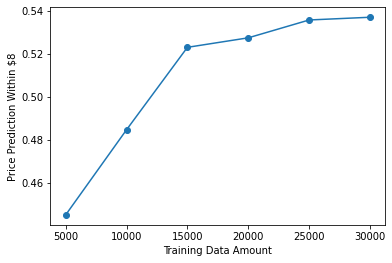

In [ ]:
# Plot accuracy vs each of the training subsets generated in the cell above
fig,ax = plt.subplots(1)
ax.plot(training_sizes, accuracies)
ax.scatter(training_sizes, accuracies)
plt.xlabel("Training Data Amount")
plt.ylabel("Price Prediction Within $8")
plt.savefig('graph.png')